<a href="https://colab.research.google.com/github/LanceLiang2011/colab_projects/blob/main/DogImageClassifier/DogImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and TensorFlow hub to Classify Different Dog Breeds

This project employs transfer learning for multi-class image classification, with a specific focus on recognizing different breeds of dogs using image data. The dataset, sourced from a [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification/overview), comprises over 10,000 labeled images spanning 120 distinct dog breeds.

We follow a classic TensorFlow/Deep Learning workflow:

1. Data Acquisition: Retrieve the dataset from Kaggle, store, and import it into our project.
2. Data Preparation: Preprocess the data to create three distinct sets and segregate the features (X) and targets (y).
3. Model Selection and Training: Choose an appropriate model from TensorFlow Hub or tf.keras.applications and train it using tools like TensorBoard and EarlyStopping for optimal performance.
4. Model Evaluation: Predict outcomes using the trained model and compare these predictions with the ground truth labels to assess the model's accuracy. According to Kaggle, submissions are evaluated on **Multi Class Log Loss** between the predicted probability and the observed target.
5. Model Optimization: Improve the model iteratively by starting with a small sample size (e.g., 1000 images) to ensure functionality, then gradually increase the amount of data for enhanced precision.
6. Model Persistence: Once satisfied with the model's performance, save and share the model for future use and reload it as necessary.

## Enviroment Setup and Data Acquisition

I downloaded data from Kaggle and upload it into Google Drive. I am unzipping it for further usage.

Then I setup tensorflow hub and GPU usage.

Finally I load the data and labels

In [42]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/dog-vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Notebooks/dog-vision/data"

In [43]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("TensorFlow version:",tf.__version__)

TensorFlow version: 2.12.0


In [44]:
# importing TensorFlow Hub
import tensorflow_hub as hub
print("TensorFlow Hub version:",hub.__version__)
# Using colab GPU
print("GPU avaliable" if tf.config.list_physical_devices("GPU") else "GPU not avaliable")

TensorFlow Hub version: 0.13.0
GPU not avaliable


In [45]:
# Checkout labels of data
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dog-vision/data/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [46]:
labels_csv.breed.describe()

count                  10222
unique                   120
top       scottish_deerhound
freq                     126
Name: breed, dtype: object

<Axes: >

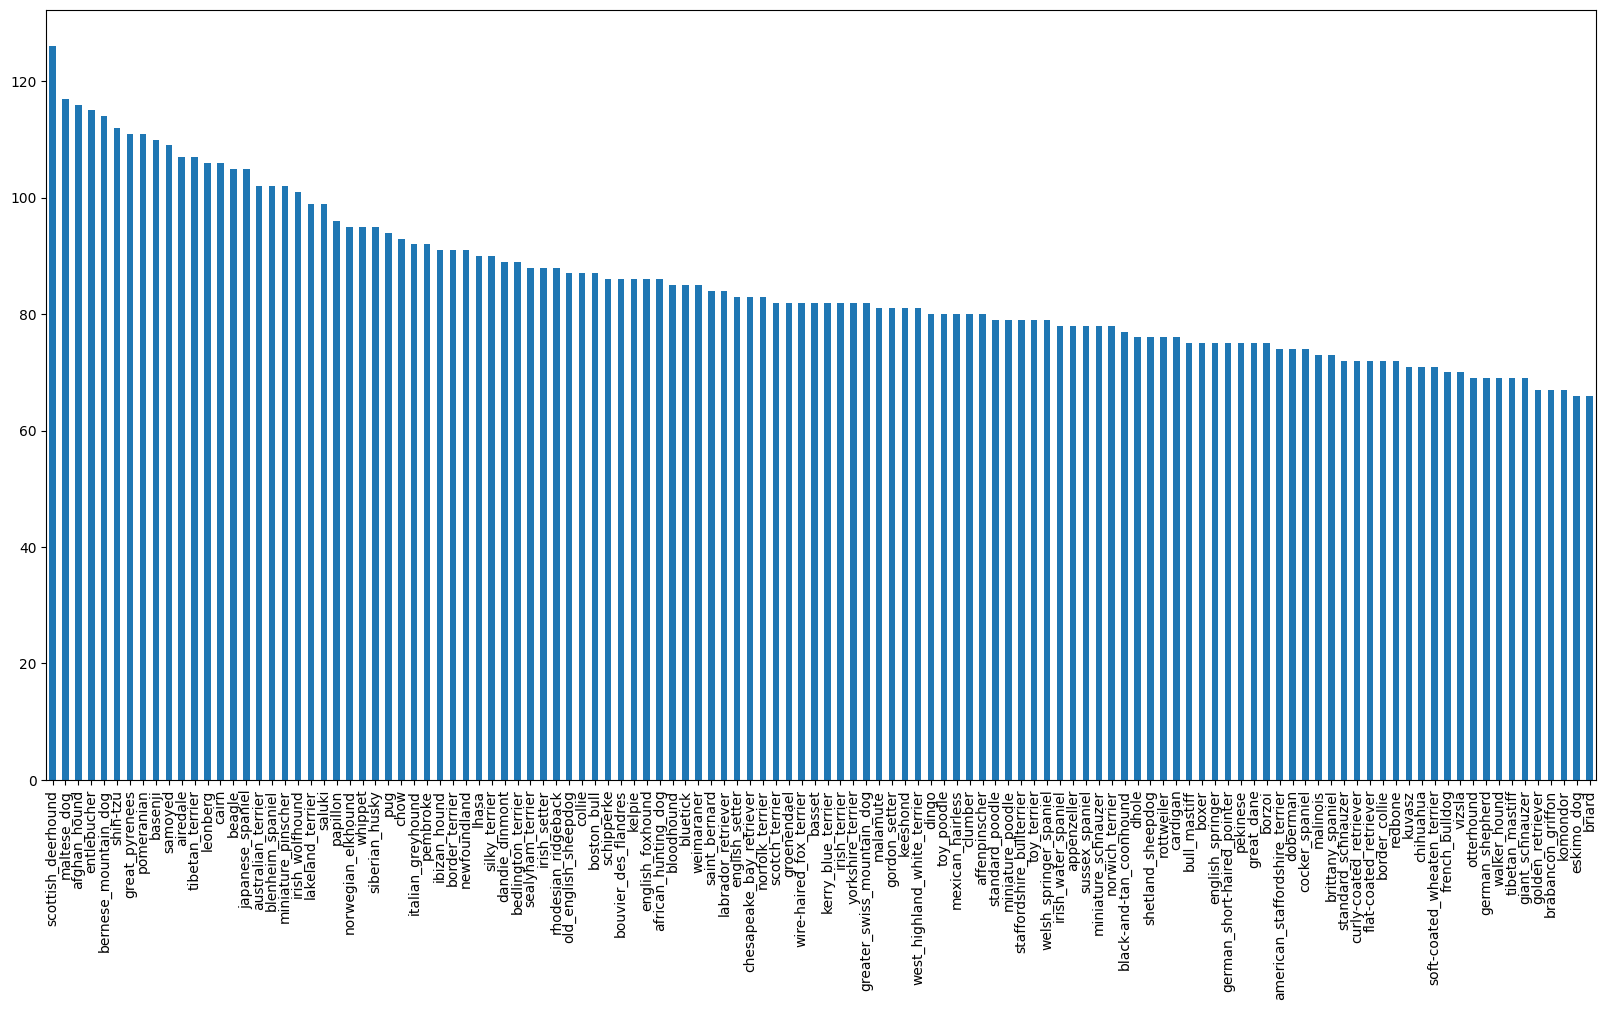

In [47]:
# visualize 120 dog breeds
labels_csv.breed.value_counts().plot.bar(figsize=(20,10))

**Based on the displayed breed label distribution, we observe a reasonably balanced representation across the different breeds. This means that no specific breed is drastically underrepresented or overrepresented in our dataset. The annotations for each label are around 60-120, which is recommended(https://cloud.google.com/vision/automl/object-detection/docs/prepare)**

## Data Preparing

In this section, I prepare the data by turning images into tensors and labels into numbers

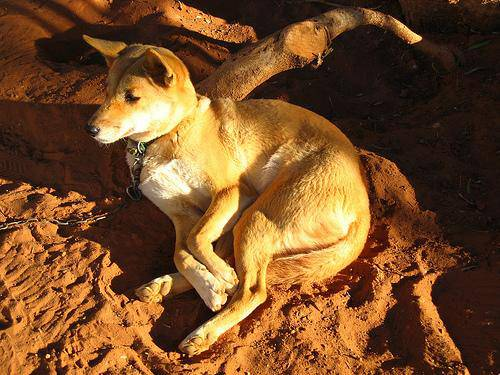

In [48]:
# first show one image example
from IPython.display import display, Image
Image("/content/drive/MyDrive/Colab Notebooks/dog-vision/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")
# This is the dingo with ID 001513dfcb2ffafc82cccf4d8bbaba97 we've seen in the label dataset

### Getting Image-Label pair

For further analysis and training, I will get a list of images and file pathnames

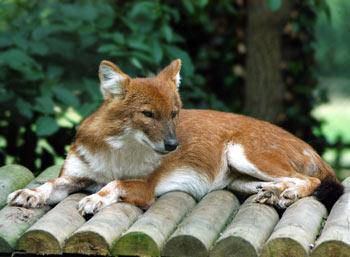

In [49]:
# Create pathname using image ids
filenames = [f"/content/drive/MyDrive/Colab Notebooks/dog-vision/data/train/{fname}.jpg" for fname in labels_csv.id]
Image(filenames[42]) #get the index 42 image from filenames/ sanity check

In [50]:
# Sanity check: if number of filenames matches number of image files in folder
import os
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/dog-vision/data/train")) == len(filenames):
  print("✅")
else:
  print("❌")

✅


### Turn labels from strings into numbers

Let's improve the paragraph to make it more concise and precise:

Leveraging the DataFrame labels_csv, which contains image IDs and corresponding labels, we intend to construct:

* A list of filepaths for the training images,
* An array encompassing all labels, and
* An array containing unique labels.

By opting to create a list of image filepaths rather than importing all the images initially, we enhance the efficiency of our process. This strategy is advantageous as working with filepaths (strings) is considerably more resource-friendly than directly handling image data.

In [51]:
labels = labels_csv.breed.to_numpy()
len(labels)

10222

In [52]:
if len(labels) == len(filenames):
  print("✅")
else:
  print("❌")

✅


In [53]:
# Find unique labels
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

**I plan to convert each label into an array of boolean values, where 'True' signifies that the input image belongs to the corresponding breed.**

In [54]:
boolean_labels = np.array([label == unique_breeds for label in labels])
boolean_labels.shape

(10222, 120)

In [55]:
# One hot code from False, True to  0,1
int_labels = boolean_labels.astype(int)
int_labels, int_labels.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (10222, 120))

In [56]:
# Sanity check
labels[0], \
int_labels[0], \
int_labels.argmax() # using argmax to get the index = label==1

('boston_bull',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 19)

### Train Validate Split
Since the dataset from Kaggle doesn't come with a validation set, let's make one.

In [57]:
X = filenames
y = boolean_labels

In [58]:
# Set a number for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [59]:
# Split to train validation
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2, 
                                                  random_state=42)

In [61]:
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [62]:
# Sanity Check
# X_train[:5], y_val[:2]

### Preprocessing Image (Image to Tensors)

In this subsection, I transform the image data from .jpg file to tensors that make sense to deep learning models
1. Take filepath as input
2. Use TensorFlow to read the file and save to `image` valiable
3. Transfer images to flow
4. Normalize images based on [common image input conventions](https://www.tensorflow.org/hub/common_signatures/images#input)
5. Resize image (224,224) as this is what the [model we use](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5) expects.

In [63]:
from matplotlib.pyplot import imread

In [64]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Transforms an image located at the given path into a Tensor.

  Parameters:
  image_path: str, file path to the image file.
  
  Returns:
  Tensor representation of the image with normalized and resized values.
  """
  # Read image
  image = tf.io.read_file(image_path)
  # turn jpeg image into tensor with 3 color chanels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalize value (convert color chanel values from 0-255 to 0-1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Turn data into batches

make batche size to classic 32

1. Get a simple function to turn our image file path names and their associated labels into tuples.
2. Create a function to make data batches.

In [65]:
def get_image_label(image_path, label):
  """
  Fetches the image file and associates it with its label.

  Parameters:
  image_path: str, File path to the image.
  label: The corresponding label of the image.

  Returns:
  tuple: A tuple containing the processed image tensor and its associated label.
  """
  image = process_image(image_path)
  return (image, label)

In [66]:
# get_image_label(X[42],tf.constant(y[42]))

In [67]:
BATCH_SIZE = 32

def create_data_batches (X, y=None, batch_size = BATCH_SIZE, valid_data=False, test_data=False):
  """
  Constructs batches of data from image paths (x) and associated labels (y).
  The data is shuffled for training sets but remains ordered for validation sets.
  If provided with test data, the function accepts it without labels.

  Parameters:
  x: List of image paths.
  y: Corresponding labels. None if test_data is True.
  batch_size: Number of samples per batch. Default is BATCH_SIZE.
  valid_data: Boolean indicating if the data is a validation set.
  test_data: Boolean indicating if the data is a test set.

  Returns:
  Tensorflow batched data object ready for model ingestion.
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # test data has no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  if valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((
        tf.constant(X),
        tf.constant(y)
    ))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  print("Creating training data batches...")
  data = tf.data.Dataset.from_tensor_slices((
      tf.constant(X),
      tf.constant(y)
  ))
  # Shuffle data
  data = data.shuffle(buffer_size=len(X))
  data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  return data_batch

In [68]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [69]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualize batches

Built a function to visualize batches for better understanding the data batches.

In [70]:
def show_25_imgs(images, labels):
  """
  Display a plot of 25 images and their labels from a databatch
  """
  fig, axs = plt.subplots(5,5,figsize=(10, 10))
  axs = axs.ravel()
  for i in range(25):
    axs[i].imshow(images[i])
    axs[i].set_title(unique_breeds[labels[i].argmax()])
    axs[i].axis('off')
  plt.tight_layout()


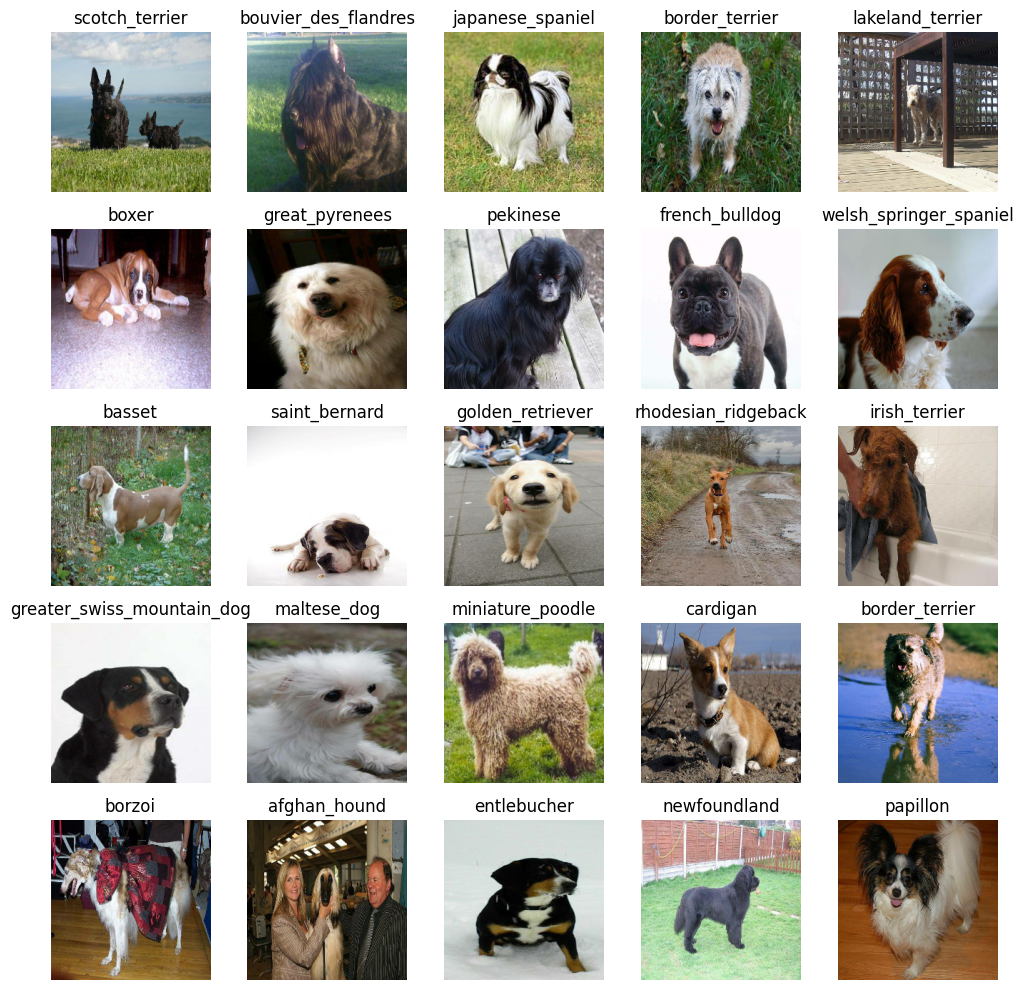

In [71]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_imgs(train_images, train_labels)

## Building a model

In this project, we'd like to use TensorFlow Hub to build a transfer learning model. There are three main points we should figure out:
* Input shape
* Output shape
* URL of model to use
[imagenet/mobilenet_v2_130_224/classification](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [72]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch height, width, color chanels
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

**Build the Keras deep learning model**

In [73]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  """
  This function creates a Keras model for classifying images.

  Parameters:
  input_shape : tuple, optional
      The shape of the input data (image), by default INPUT_SHAPE.
  output_shape : int, optional
      The number of classes for output, by default OUTPUT_SHAPE.
  model_url : str, optional
      The URL of the pre-trained TensorFlow model to use, by default MODEL_URL.

  Returns:
  model : keras.Model
      A compiled Keras model ready for training.

  The model is a simple two-layer sequential network. The first layer is a 
  pre-trained model loaded from TensorFlow Hub. The second layer is a dense 
  layer with a softmax activation function for multi-class classification.

  The model is compiled with the Adam optimizer and the categorical 
  cross-entropy loss function, suitable for multi-class classification.
  The model's performance is evaluated based on accuracy.
  """
  print(f"Building model with {model_url} ...")
  # Setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # Layer1: input layer
      tf.keras.layers.Dense(units=output_shape, activation="softmax"), 
      # outputlayer, softmax for multi-class classification
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), 
      # CategoricalCrossentropy for multi-class classification
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"],
  )
  # Build model
  model.build(input_shape)
  # Return model
  return model

In [74]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5 ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Setting up callbacks

Callbacks are supportive functions used during model training for tasks like saving progress, checking progress, or stopping training early if a model's performance plateaus. Two important callbacks are the TensorBoard callback and the Early Stopping callback.

### TensorBoard callback
TensorBoard callback offers a graphical approach to observe and evaluate the model's performance metrics, such as loss and accuracy, during and after the model training. 

To implement it in a Jupyter notebook:

1. Initiate the TensorBoard notebook extension.
2. Develop a TensorBoard callback that can store logs in a specific directory, and incorporate this into the model's fit() function.
3. Use the %tensorboard magic command to visually represent the training logs.

In [75]:
# Initiate the TensorBoard notebook extension.

%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
# Develop a TensorBoard callback
def create_tensorboard_callback():
  log_dir = os.path.join(
      '/content/drive/MyDrive/Colab Notebooks/dog-vision/logs',
      datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
      )
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Early Stopping Callback

The Early Stopping callback aids in mitigating overfitting by terminating the model training when a specific performance measure ceases to improve.

In [77]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=3
    )

## Training a model

Before training the model using the whole dataset, I will first use a 1000 images(800 for training and 200 for validating) to test if the model works.

The hyper-parameter we should adjust here is the num_epoches.

In [84]:
# setup NUM_EPOCHS
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [85]:
def train_model():
  """
  Train a given model and return the trained version.
  """
  model = create_model()

  # create new TensorBoard session evertime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping]
            )
  return model


In [86]:
model = train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5 ...
Epoch 1/10
25/25 [==============================] - 67s 3s/step - loss: 4.5213 - accuracy: 0.1075 - val_loss: 3.3123 - val_accuracy: 0.2900
Epoch 2/10
25/25 [==============================] - 67s 3s/step - loss: 1.5998 - accuracy: 0.7050 - val_loss: 2.1149 - val_accuracy: 0.5200
Epoch 3/10
25/25 [==============================] - 52s 2s/step - loss: 0.5626 - accuracy: 0.9337 - val_loss: 1.6558 - val_accuracy: 0.5850
Epoch 4/10
25/25 [==============================] - 53s 2s/step - loss: 0.2520 - accuracy: 0.9887 - val_loss: 1.4717 - val_accuracy: 0.6550
Epoch 5/10
25/25 [==============================] - 66s 3s/step - loss: 0.1455 - accuracy: 0.9987 - val_loss: 1.4050 - val_accuracy: 0.6600
Epoch 6/10
25/25 [==============================] - 52s 2s/step - loss: 0.0989 - accuracy: 1.0000 - val_loss: 1.3522 - val_accuracy: 0.6450
Epoch 7/10
25/25 [==============================] - 63s 3s/step 

### Checking the TensorBoard logs

TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and viualize its contents.

In [ ]:
%tensorboard --logdir 